# Fine tune DNN parameters

### Note that you have to execute the first 4 cells and then you can execute each part of this notebook separately

This notebook's aim is to find appropriate parameters and the best loss function for the implemented deep neural network which optimize training speed and provide a coherent, diversified trading strategy. We experiment with the first 7 months of data (6 months for training and 1 month for testing) as this will be the rolling window used in the final strategy.

In [1]:
import torch
import numpy as np
import pandas as pd
import os
import DNN_utils as utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from importlib import reload


In [2]:
# Set these right after importing torch, before any other operations
torch.set_num_threads(os.cpu_count())
torch.set_num_interop_threads(os.cpu_count())
path = 'Targets/daily_crsp_sanitized.csv'

In [3]:
daily = utils.read_daily_returns(path, nrows=1600000, low_quantile=0.005, up_quantile=0.995)
daily

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1
0,2000-01-31,5,15580,6320,0,-0.068182,0.025218,0.00000
1,2000-01-31,7,14593,3573,0,0.020910,0.025218,0.00000
2,2000-01-31,25,62770,6711,0,0.041045,0.025218,0.00000
3,2000-01-31,29,59184,2082,0,0.011236,0.025218,0.00000
4,2000-01-31,33,59248,2082,0,0.034667,0.025218,0.00000
...,...,...,...,...,...,...,...,...
1441513,2000-10-05,7557,87426,3442,0,0.000000,0.001367,0.00551
1441514,2000-10-05,7558,90879,8090,0,0.051095,0.001367,0.00551
1441515,2000-10-05,7569,86685,6020,0,0.007500,0.001367,0.00551
1441516,2000-10-05,7572,89675,3312,0,-0.050463,0.001367,0.00551


In [4]:
# Get data frame of unique months
daily['year_month'] = daily['date'].dt.to_period('M')
unique_months = daily['year_month'].drop_duplicates().sort_values()
unique_months

0          2000-01
8329       2000-02
174757     2000-03
365885     2000-04
523862     2000-05
706883     2000-06
889939     2000-07
1056371    2000-08
1248826    2000-09
1415409    2000-10
Name: year_month, dtype: period[M]

## First run: 30 epochs, regularized softmax loss function

In [5]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [6]:
epochs = 30
max_weight = 0.05  # No stock >5% weight
diversification_lambda = 0.01  # Strength of penalty
temperature = 1.0  # Softmax temperature (lower = more diversification)
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)

Starting training with 435 train batches, 41 test batches


Training:   3%|█▏                                | 1/30 [00:13<06:22, 13.19s/it]

Epoch 1/30, Loss: -0.0714, Train Sharpe: 0.0120, Test Sharpe: -0.0077, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  10%|███▍                              | 3/30 [00:40<06:08, 13.64s/it]

Epoch 3/30, Loss: -0.0936, Train Sharpe: 0.0401, Test Sharpe: 0.0273, Avg Weight: 0.0002, Max Weight: 0.0010


Training:  17%|█████▋                            | 5/30 [01:08<05:42, 13.72s/it]

Epoch 5/30, Loss: -0.1105, Train Sharpe: 0.0505, Test Sharpe: 0.0357, Avg Weight: 0.0002, Max Weight: 0.0016


Training:  23%|███████▉                          | 7/30 [01:35<05:17, 13.79s/it]

Epoch 7/30, Loss: -0.1177, Train Sharpe: 0.0561, Test Sharpe: 0.0365, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  30%|██████████▏                       | 9/30 [02:03<04:48, 13.72s/it]

Epoch 9/30, Loss: -0.1213, Train Sharpe: 0.0592, Test Sharpe: 0.0387, Avg Weight: 0.0002, Max Weight: 0.0019


Training:  37%|████████████                     | 11/30 [02:30<04:20, 13.73s/it]

Epoch 11/30, Loss: -0.1247, Train Sharpe: 0.0611, Test Sharpe: 0.0405, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  43%|██████████████▎                  | 13/30 [02:57<03:52, 13.67s/it]

Epoch 13/30, Loss: -0.1266, Train Sharpe: 0.0636, Test Sharpe: 0.0388, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  50%|████████████████▌                | 15/30 [03:25<03:24, 13.63s/it]

Epoch 15/30, Loss: -0.1296, Train Sharpe: 0.0654, Test Sharpe: 0.0388, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  57%|██████████████████▋              | 17/30 [03:56<03:12, 14.80s/it]

Epoch 17/30, Loss: -0.1316, Train Sharpe: 0.0663, Test Sharpe: 0.0383, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  63%|████████████████████▉            | 19/30 [04:25<02:41, 14.64s/it]

Epoch 19/30, Loss: -0.1326, Train Sharpe: 0.0664, Test Sharpe: 0.0363, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  70%|███████████████████████          | 21/30 [04:53<02:09, 14.41s/it]

Epoch 21/30, Loss: -0.1343, Train Sharpe: 0.0678, Test Sharpe: 0.0368, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  77%|█████████████████████████▎       | 23/30 [05:21<01:38, 14.12s/it]

Epoch 23/30, Loss: -0.1358, Train Sharpe: 0.0685, Test Sharpe: 0.0371, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  83%|███████████████████████████▌     | 25/30 [05:49<01:10, 14.01s/it]

Epoch 25/30, Loss: -0.1363, Train Sharpe: 0.0694, Test Sharpe: 0.0371, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  90%|█████████████████████████████▋   | 27/30 [06:16<00:41, 13.87s/it]

Epoch 27/30, Loss: -0.1377, Train Sharpe: 0.0701, Test Sharpe: 0.0377, Avg Weight: 0.0002, Max Weight: 0.0022


Training:  97%|███████████████████████████████▉ | 29/30 [06:44<00:13, 13.83s/it]

Epoch 29/30, Loss: -0.1389, Train Sharpe: 0.0708, Test Sharpe: 0.0373, Avg Weight: 0.0002, Max Weight: 0.0022


Training: 100%|█████████████████████████████████| 30/30 [06:58<00:00, 13.96s/it]

Epoch 30/30, Loss: -0.1395, Train Sharpe: 0.0706, Test Sharpe: 0.0374, Avg Weight: 0.0002, Max Weight: 0.0022
Training completed! Best test Sharpe ratio: 0.0405


In [7]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

test_df['weight'].describe()

count    1.664320e+05
mean     2.463469e-04
std      3.490750e-04
min      1.094414e-29
25%      5.765506e-06
50%      6.997278e-05
75%      3.615458e-04
max      2.160486e-03
Name: weight, dtype: float64

Weights are nicely spread out. The strategy is successfully diversified unlike the strategy which directly maximizes Sharpe ratio. 

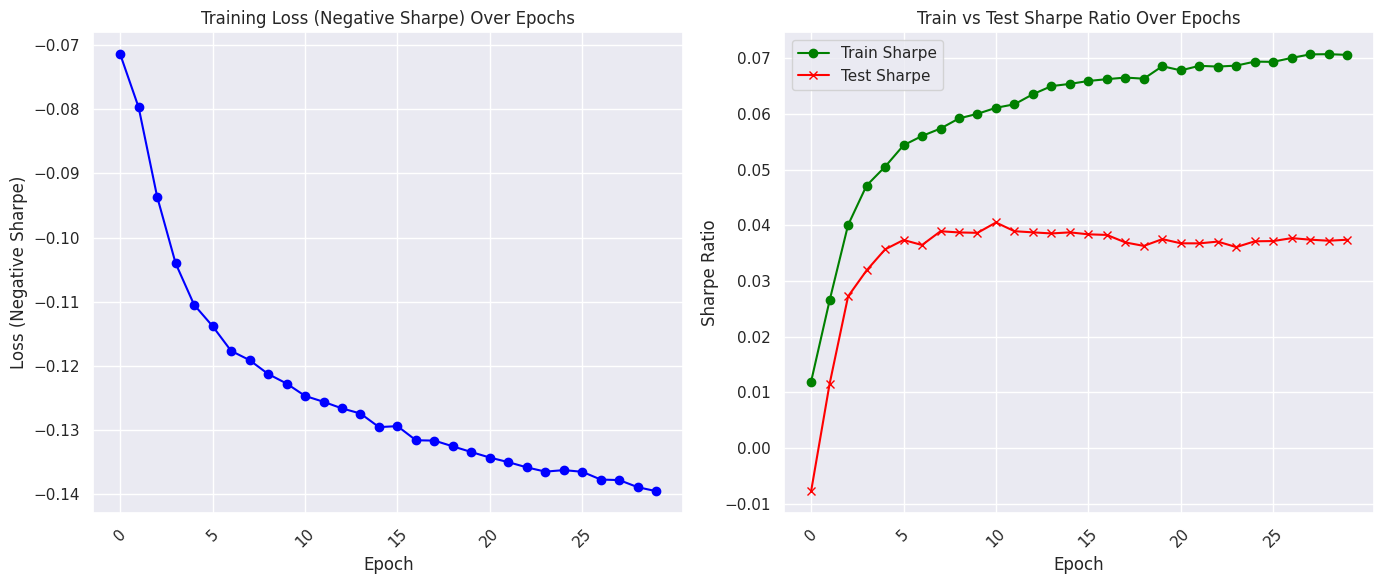

In [8]:
reload(utils) # In case the python module is modified
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

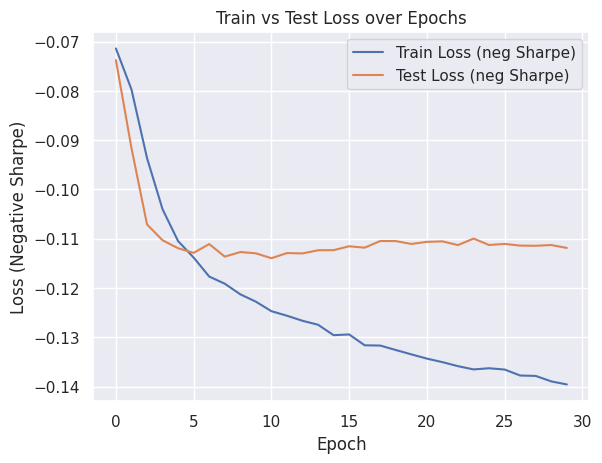

In [9]:
utils.plot_train_vs_test(range(0, epochs), train_losses, test_losses)

As can be seen by the above plots, the out of sample Sharpe ratio doesn't increase much further after 4-5 epochs. Therefore there is no point training the model on many epochs. 

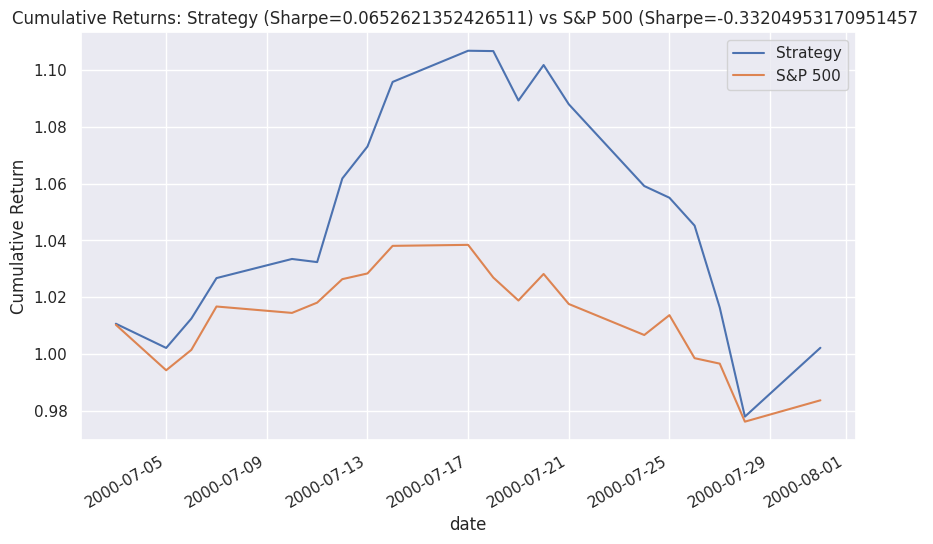

In [10]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

## Second run: negative Sharpe ratio loss 

It seems a high number of epochs isn't necessary for convergence for the regularized softmax function. However, this may not be the case for other loss functions. Actually, it reduces out of sample Sharpe ratio as it overfits the training data. We can train faster using less epochs and a higher learning rate. The above plots suggest 3 epochs is sufficient. However, since this is quite low, we first try with 10 and a faster learning rate of 0.01 instead of 0.001.

In [11]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [12]:
epochs = 20
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, _ = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'neg_sharpe')

Starting training with 435 train batches, 41 test batches


Training:   5%|█▋                                | 1/20 [00:17<05:23, 17.01s/it]

Epoch 1/20, Loss: -0.0151, Train Sharpe: 0.0169, Test Sharpe: 0.0214


Training:  15%|█████                             | 3/20 [00:45<04:11, 14.77s/it]

Epoch 3/20, Loss: -0.0434, Train Sharpe: 0.0450, Test Sharpe: 0.0573


Training:  25%|████████▌                         | 5/20 [01:18<04:03, 16.24s/it]

Epoch 5/20, Loss: -0.0563, Train Sharpe: 0.0499, Test Sharpe: 0.0567


Training:  35%|███████████▉                      | 7/20 [01:46<03:14, 14.97s/it]

Epoch 7/20, Loss: -0.0595, Train Sharpe: 0.0544, Test Sharpe: 0.0572


Training:  45%|███████████████▎                  | 9/20 [02:15<02:41, 14.70s/it]

Epoch 9/20, Loss: -0.0650, Train Sharpe: 0.0578, Test Sharpe: 0.0572


Training:  55%|██████████████████▏              | 11/20 [02:46<02:16, 15.17s/it]

Epoch 11/20, Loss: -0.0685, Train Sharpe: 0.0644, Test Sharpe: 0.0573


Training:  65%|█████████████████████▍           | 13/20 [03:19<01:49, 15.64s/it]

Epoch 13/20, Loss: -0.0728, Train Sharpe: 0.0689, Test Sharpe: 0.0561


Training:  75%|████████████████████████▊        | 15/20 [03:52<01:20, 16.18s/it]

Epoch 15/20, Loss: -0.0760, Train Sharpe: 0.0756, Test Sharpe: 0.0555


Training:  85%|████████████████████████████     | 17/20 [04:25<00:48, 16.33s/it]

Epoch 17/20, Loss: -0.0788, Train Sharpe: 0.0792, Test Sharpe: 0.0549


Training:  95%|███████████████████████████████▎ | 19/20 [05:00<00:16, 16.91s/it]

Epoch 19/20, Loss: -0.0818, Train Sharpe: 0.0822, Test Sharpe: 0.0543


Training: 100%|█████████████████████████████████| 20/20 [05:17<00:00, 15.87s/it]

Epoch 20/20, Loss: -0.0826, Train Sharpe: 0.0835, Test Sharpe: 0.0537
Training completed! Best test Sharpe ratio: 0.0582


In [13]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['raw_predictions'] = raw_predictions.values
def softmax(x):
        e_x = np.exp(x - np.max(x))  # Subtract max for numerical stability
        return e_x / e_x.sum()
    
# Apply softmax within each date group
test_df['weight'] = test_df.groupby('date')['raw_predictions'].transform(softmax)
    
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))

test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
test_df['return_no_cost'] = test_df['weight'] * test_df['DlyRet']

mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_returns_no_cost = test_df.groupby('date')['return_no_cost'].sum()

test_df['weight'].describe()

count    1.664320e+05
mean     1.201692e-04
std      8.874232e-03
min      4.799447e-42
25%      4.418873e-24
50%      7.736114e-21
75%      3.646214e-17
max      9.999863e-01
Name: weight, dtype: float64

As we can observe, maximizing the Sharpe ratio directly is a bad idea as it forces the model to invest all of its money in a single stock. There is no diversification and transaction costs kill any profit the strategy may make. 

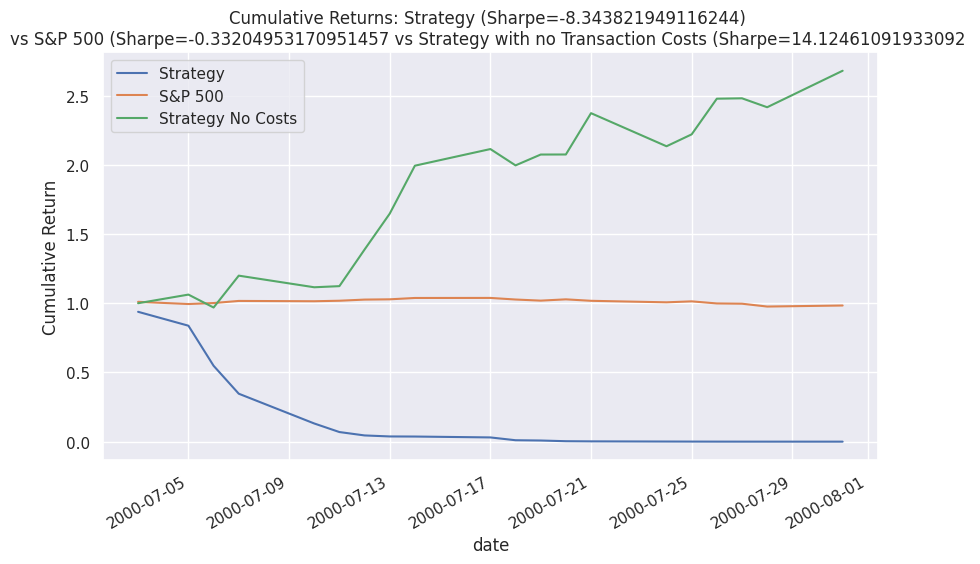

In [14]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
cum_ret_no_cost = (1 + mean_returns_no_cost).cumprod()
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500,
    'Strategy No Costs': cum_ret_no_cost
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())
strat_sharpe_no_tc = np.sqrt(cum_ret_no_cost.shape[0]) * (cum_ret_no_cost.mean() / cum_ret_no_cost.std() + 10e-8)

# Plot
combined.plot(figsize=(10, 6), title=f'''Cumulative Returns: Strategy (Sharpe={strat_sharpe}) 
vs S&P 500 (Sharpe={sp_sharpe} vs Strategy with no Transaction Costs (Sharpe={strat_sharpe_no_tc} ''')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

We can see that the transaction costs, especially the quadratic costs kill the strategy's returns, making it lose all of the money invested after only 2 weeks. 

# Third run: linear rank-based loss 

In [15]:
reload(utils) # In case the python module is modified

# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (daily['year_month'] >= train_start) & (daily['year_month'] <= train_end)
test_mask = daily['year_month'] == test_month

tr_df = daily[train_mask].copy()
te_df = daily[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [16]:
epochs = 20
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, loss_function = 'lin_rank')

Starting training with 435 train batches, 41 test batches


Training:   5%|█▋                                | 1/20 [00:27<08:50, 27.94s/it]

Epoch 1/20, Loss: -0.0039, Train Sharpe: 0.0041, Test Sharpe: -0.0062, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  15%|█████                             | 3/20 [01:26<08:12, 28.99s/it]

Epoch 3/20, Loss: -0.0065, Train Sharpe: 0.0120, Test Sharpe: 0.0161, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  25%|████████▌                         | 5/20 [02:26<07:25, 29.70s/it]

Epoch 5/20, Loss: -0.0369, Train Sharpe: 0.0505, Test Sharpe: 0.0455, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  35%|███████████▉                      | 7/20 [03:19<06:04, 28.05s/it]

Epoch 7/20, Loss: -0.0429, Train Sharpe: 0.0533, Test Sharpe: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  45%|███████████████▎                  | 9/20 [04:12<04:58, 27.11s/it]

Epoch 9/20, Loss: -0.0460, Train Sharpe: 0.0507, Test Sharpe: 0.0421, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  55%|██████████████████▏              | 11/20 [05:06<04:02, 26.98s/it]

Epoch 11/20, Loss: -0.0466, Train Sharpe: 0.0539, Test Sharpe: 0.0355, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  65%|█████████████████████▍           | 13/20 [06:14<03:36, 30.89s/it]

Epoch 13/20, Loss: -0.0461, Train Sharpe: 0.0544, Test Sharpe: 0.0392, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  75%|████████████████████████▊        | 15/20 [07:12<02:30, 30.06s/it]

Epoch 15/20, Loss: -0.0474, Train Sharpe: 0.0560, Test Sharpe: 0.0359, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  85%|████████████████████████████     | 17/20 [08:08<01:26, 28.83s/it]

Epoch 17/20, Loss: -0.0487, Train Sharpe: 0.0570, Test Sharpe: 0.0397, Avg Weight: 0.0002, Max Weight: 0.0077


Training:  95%|███████████████████████████████▎ | 19/20 [09:20<00:31, 31.99s/it]

Epoch 19/20, Loss: -0.0507, Train Sharpe: 0.0573, Test Sharpe: 0.0421, Avg Weight: 0.0002, Max Weight: 0.0077


Training: 100%|█████████████████████████████████| 20/20 [09:53<00:00, 29.67s/it]

Epoch 20/20, Loss: -0.0499, Train Sharpe: 0.0578, Test Sharpe: 0.0401, Avg Weight: 0.0002, Max Weight: 0.0077
Training completed! Best test Sharpe ratio: 0.0468


In [17]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))

test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']

mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()

test_df['weight'].describe()

count    166432.000000
mean          0.000246
std           0.000867
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.007678
Name: weight, dtype: float64

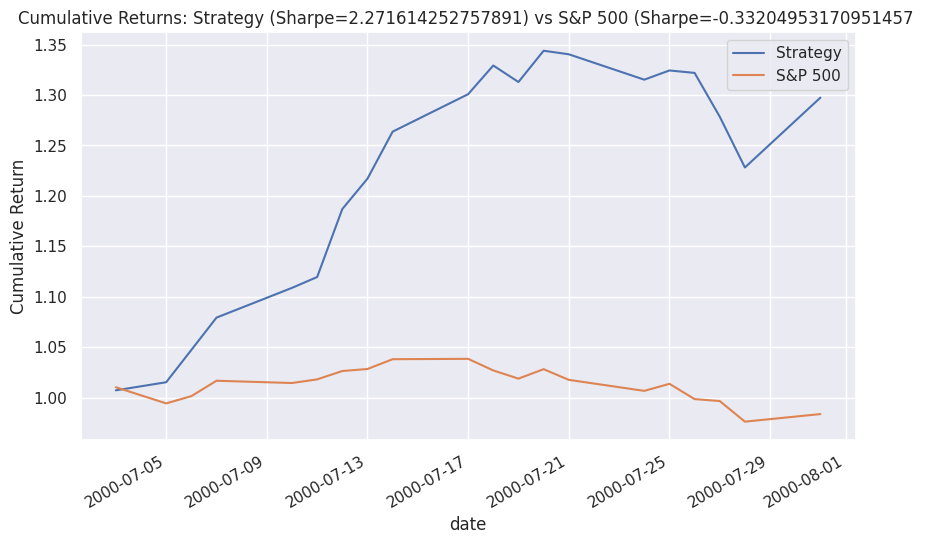

In [18]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

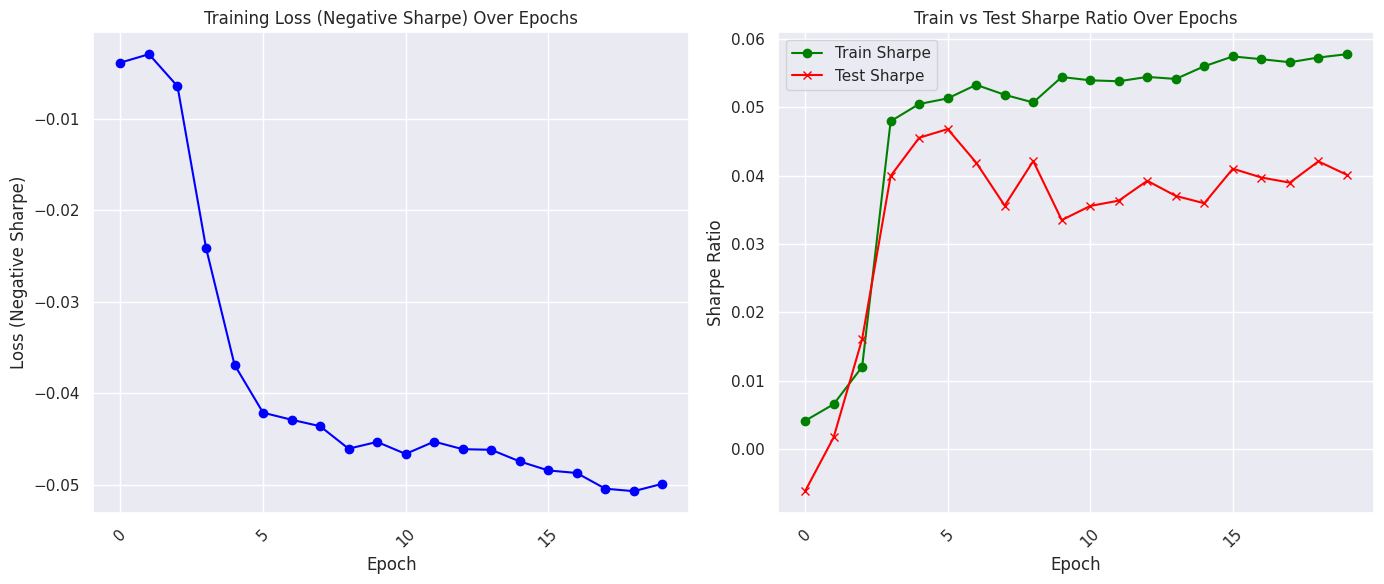

In [19]:
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)

# Fourth run: include firm characteristics index

So far, we have been training the model using past returns. Let's see if including firm characteristics adds any information. 

In [20]:
index = pd.read_csv('Predictors/FirmCharacIndex.csv')
index

,Unnamed: 0,date,PERMNO,gvkey,pls_index
0,0,2000-01-31,10025,11903,-2.952353
1,1,2000-01-31,10089,12143,-1.524411
2,2,2000-01-31,10155,12094,-3.268681
3,3,2000-01-31,10182,12171,5.057577
4,4,2000-01-31,10256,12226,-3.156031
...,...,...,...,...,...
518548,518548,2024-12-31,93426,185138,-0.058808
518549,518549,2024-12-31,93427,179583,3.319067
518550,518550,2024-12-31,93429,184500,4.477921
518551,518551,2024-12-31,93434,184259,-3.595867


In [21]:
import gc
gc.collect()
reload(utils)
merged_data = utils.memory_efficient_merge(index, daily)

Processing PERMNOs: 100%|████████████████| 14465/14465 [00:37<00:00, 390.01it/s]


In [22]:
merged_data = merged_data.drop(columns=['PERMNO_y'])
merged_data = merged_data.rename(columns={'PERMNO_x': 'PERMNO'})
merged_data

,date,PERMCO,PERMNO,SICCD,NAICS,DlyRet,sprtrn,sprtrn_lag1,year_month,pls_index
0,2000-01-31,7975,10025,3070,0,0.025126,0.025218,0.000000,2000-01,-2.952353
1,2000-02-01,7975,10025,3070,0,0.019608,0.010628,0.025218,2000-02,-2.250024
2,2000-02-02,7975,10025,3070,0,0.030769,-0.000114,0.010628,2000-02,-2.250024
3,2000-02-03,7975,10025,3070,0,0.000000,0.011248,-0.000114,2000-02,-2.250024
4,2000-02-04,7975,10025,3070,0,0.007463,-0.000421,0.011248,2000-02,-2.250024
...,...,...,...,...,...,...,...,...,...,...
1231114,2000-09-28,18404,87759,3860,0,-0.024096,0.022235,-0.000448,2000-09,-3.378646
1231115,2000-09-29,18404,87759,3860,0,0.000000,-0.014935,0.022235,2000-09,-3.378646
1231116,2000-10-02,18404,87759,3860,0,0.000000,-0.000195,-0.014935,2000-10,-3.378646
1231117,2000-10-03,18404,87759,3860,0,0.000000,-0.006803,-0.000195,2000-10,-3.378646


In [23]:
# Train on first 6 months and test on 7th month 
train_start = unique_months.iloc[0]
train_end = unique_months.iloc[5]
test_month = unique_months.iloc[6]

# Filter data
train_mask = (merged_data['year_month'] >= train_start) & (merged_data['year_month'] <= train_end)
test_mask = merged_data['year_month'] == test_month

tr_df = merged_data[train_mask].copy()
te_df = merged_data[test_mask].copy()


train_df, test_df, features, cat_features = utils.prepare_data(tr_df, te_df, lagged_num=1, rolling_window=True)

['sprtrn_lag1', 'pls_index', 'DlyRet_lag1', 'DlyRet_roll_10', 'DlyRet_roll_20', 'DlyRet_roll_30']


In [24]:
epochs = 20
max_weight = 0.05  # No stock >5% weight
diversification_lambda = 0.01  # Strength of penalty
temperature = 1.0  # Softmax temperature (lower = more diversification)
train_losses, test_losses, train_sharpes, test_sharpes, raw_predictions, weights = utils.train_DNN(train_df, test_df, features, cat_features, 
                                                                                                   epochs=epochs, max_weight=max_weight, 
                                                                                                   diversification_lambda=diversification_lambda, 
                                                                                                   temperature=temperature)

Starting training with 372 train batches, 35 test batches


Training:   5%|█▋                                | 1/20 [00:38<12:09, 38.41s/it]

Epoch 1/20, Loss: -0.0867, Train Sharpe: 0.0183, Test Sharpe: 0.0088, Avg Weight: 0.0002, Max Weight: 0.0036


Training:  15%|█████                             | 3/20 [01:08<05:45, 20.30s/it]

Epoch 3/20, Loss: -0.1128, Train Sharpe: 0.0544, Test Sharpe: 0.0419, Avg Weight: 0.0002, Max Weight: 0.0066


Training:  25%|████████▌                         | 5/20 [01:37<04:06, 16.42s/it]

Epoch 5/20, Loss: -0.1328, Train Sharpe: 0.0579, Test Sharpe: 0.0375, Avg Weight: 0.0002, Max Weight: 0.0066


Training:  35%|███████████▉                      | 7/20 [02:05<03:17, 15.18s/it]

Epoch 7/20, Loss: -0.1368, Train Sharpe: 0.0701, Test Sharpe: 0.0422, Avg Weight: 0.0002, Max Weight: 0.0093


Training:  45%|███████████████▎                  | 9/20 [02:32<02:38, 14.40s/it]

Epoch 9/20, Loss: -0.1402, Train Sharpe: 0.0712, Test Sharpe: 0.0409, Avg Weight: 0.0002, Max Weight: 0.0082


Training:  55%|██████████████████▏              | 11/20 [02:58<02:01, 13.55s/it]

Epoch 11/20, Loss: -0.1429, Train Sharpe: 0.0764, Test Sharpe: 0.0415, Avg Weight: 0.0002, Max Weight: 0.0082


Training:  65%|█████████████████████▍           | 13/20 [03:23<01:30, 12.94s/it]

Epoch 13/20, Loss: -0.1455, Train Sharpe: 0.0764, Test Sharpe: 0.0420, Avg Weight: 0.0002, Max Weight: 0.0082


Training:  75%|████████████████████████▊        | 15/20 [03:50<01:06, 13.20s/it]

Epoch 15/20, Loss: -0.1475, Train Sharpe: 0.0806, Test Sharpe: 0.0432, Avg Weight: 0.0002, Max Weight: 0.0082


Training:  85%|████████████████████████████     | 17/20 [04:16<00:39, 13.16s/it]

Epoch 17/20, Loss: -0.1501, Train Sharpe: 0.0817, Test Sharpe: 0.0390, Avg Weight: 0.0002, Max Weight: 0.0082


Training:  95%|███████████████████████████████▎ | 19/20 [04:43<00:13, 13.23s/it]

Epoch 19/20, Loss: -0.1514, Train Sharpe: 0.0833, Test Sharpe: 0.0395, Avg Weight: 0.0002, Max Weight: 0.0082


Training: 100%|█████████████████████████████████| 20/20 [04:55<00:00, 14.79s/it]

Epoch 20/20, Loss: -0.1517, Train Sharpe: 0.0821, Test Sharpe: 0.0376, Avg Weight: 0.0002, Max Weight: 0.0082
Training completed! Best test Sharpe ratio: 0.0437


In [25]:
reload(utils)
TC_RATE = 0.003
alpha = 100

test_df['weight'] = weights.values
test_df['weight_change'] = np.abs(test_df['weight'].diff().fillna(0.0))
test_df['tc_cost'] = test_df['weight_change'].apply(lambda x: utils.progressive_cost(x, base_tc=TC_RATE, alpha=alpha))
test_df['strategy_return'] = test_df['weight'] * test_df['DlyRet'] - test_df['tc_cost']
mean_daily_returns = test_df.groupby('date')['strategy_return'].sum()
mean_daily_returns

date
2000-07-03    0.014358
2000-07-05   -0.002782
2000-07-06    0.011135
2000-07-07    0.021869
2000-07-10    0.012935
2000-07-11    0.003425
2000-07-12    0.024589
2000-07-13    0.011378
2000-07-14    0.013512
2000-07-17    0.008943
2000-07-18   -0.002853
2000-07-19   -0.005749
2000-07-20    0.007156
2000-07-21   -0.013693
2000-07-24   -0.012728
2000-07-25    0.002696
2000-07-26    0.000580
2000-07-27   -0.011601
2000-07-28   -0.022688
2000-07-31    0.014418
Name: strategy_return, dtype: float64

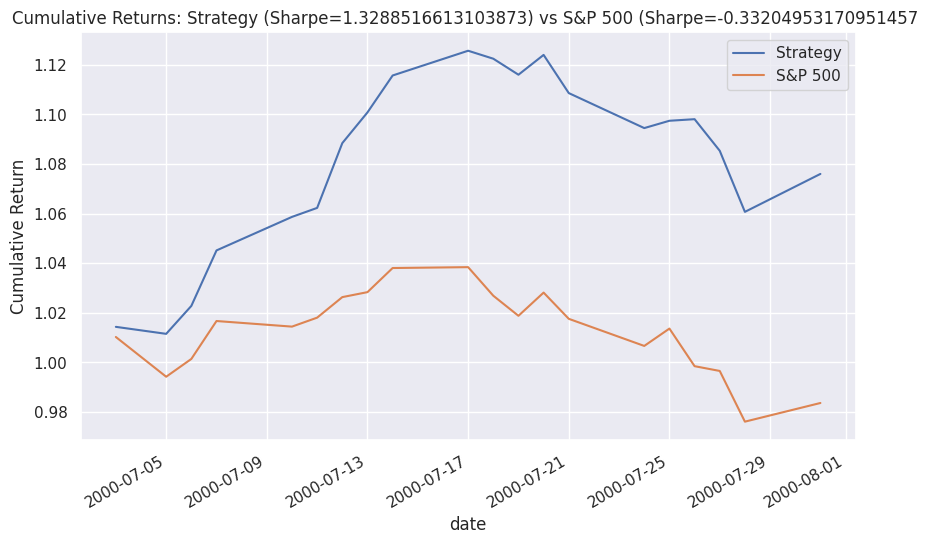

In [26]:
# Plot the cumulative returns of the strategy and compare with the S&P 500 index
cumulative_returns = (1 + mean_daily_returns).cumprod() 
sp_ret = test_df.groupby('date')['sprtrn'].mean()
cumulative_sp500 = (1 + sp_ret).cumprod()

# Combine into a single DataFrame for easy plotting
combined = pd.DataFrame({
    'Strategy': cumulative_returns,
    'S&P 500': cumulative_sp500
})

# Sharpe ratio
strat_sharpe = np.sqrt(mean_daily_returns.shape[0]) * (mean_daily_returns.mean() / mean_daily_returns.std() + 10e-8)
sp_sharpe = np.sqrt(sp_ret.shape[0]) * (sp_ret.mean() / sp_ret.std())

# Plot
combined.plot(figsize=(10, 6), title=f'Cumulative Returns: Strategy (Sharpe={strat_sharpe}) vs S&P 500 (Sharpe={sp_sharpe} ')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

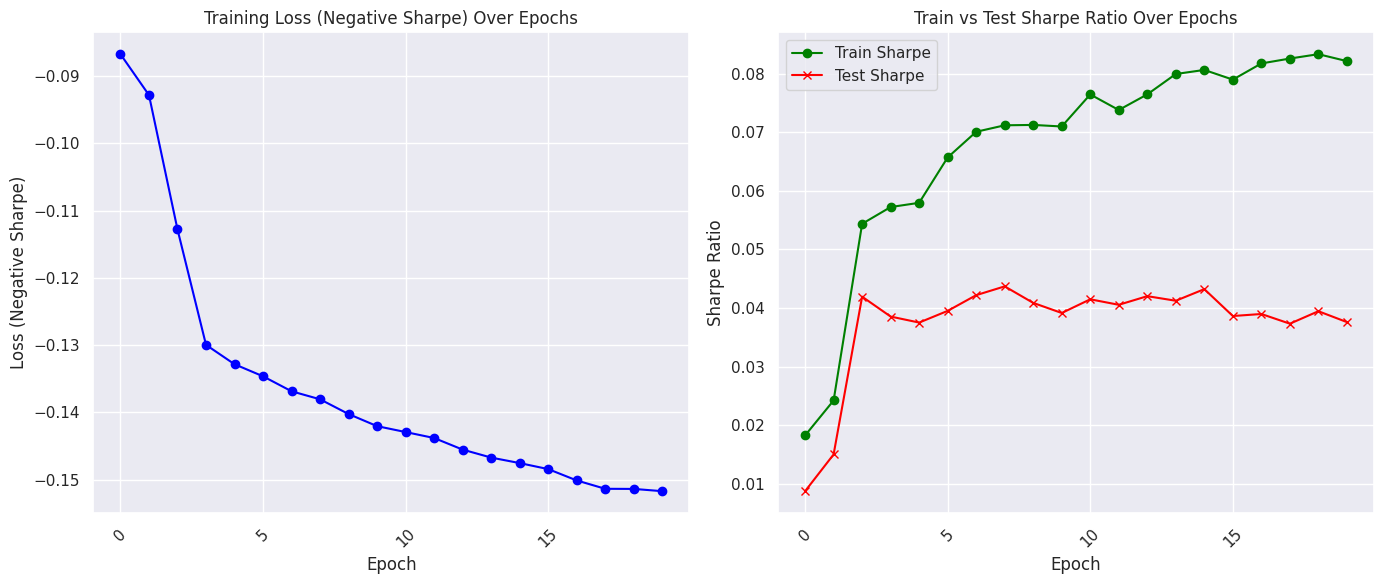

In [27]:
utils.plot_results_1(range(0, epochs), train_losses, train_sharpes, test_sharpes)